In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating overall cognition and neighbourhood unemployment
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_totalcomp_uncorrected','reshist_addr1_adi_unemp','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_unemp'].median()
data.loc[data['reshist_addr1_adi_unemp'] <= val, 'reshist_addr1_adi_unemp_bin'] = 0
data.loc[data['reshist_addr1_adi_unemp'] > val, 'reshist_addr1_adi_unemp_bin'] = 1

In [4]:
data['nihtbx_totalcomp_uncorrected_log']= np.log(data['nihtbx_totalcomp_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_totalcomp_uncorrected_log'
data['nihtbx_totalcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [6]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
unemp = data.reshist_addr1_adi_unemp_bin.values
target_values = data.nihtbx_totalcomp_uncorrected_zscore.values

In [7]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
unemp_ = shared(unemp)

In [8]:
#varying intercepts and varying slopes: 
#predicting overall cognition scores from census unemployment 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * unemp_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 803 seconds.
The number of effective samples is smaller than 25% for some parameters.


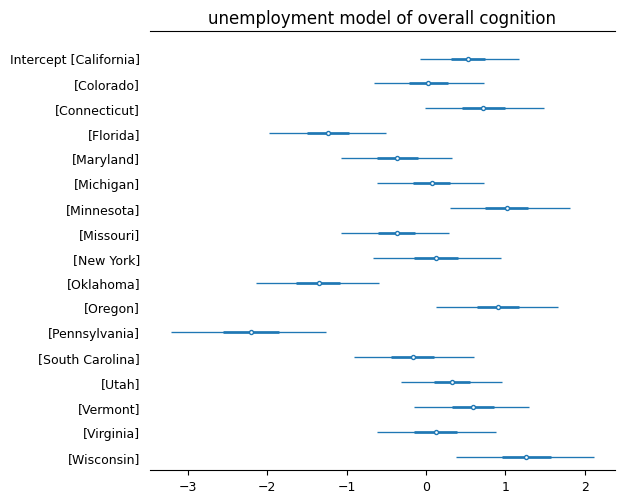

In [9]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("unemployment model of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_unemp_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_92256/1424509251.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


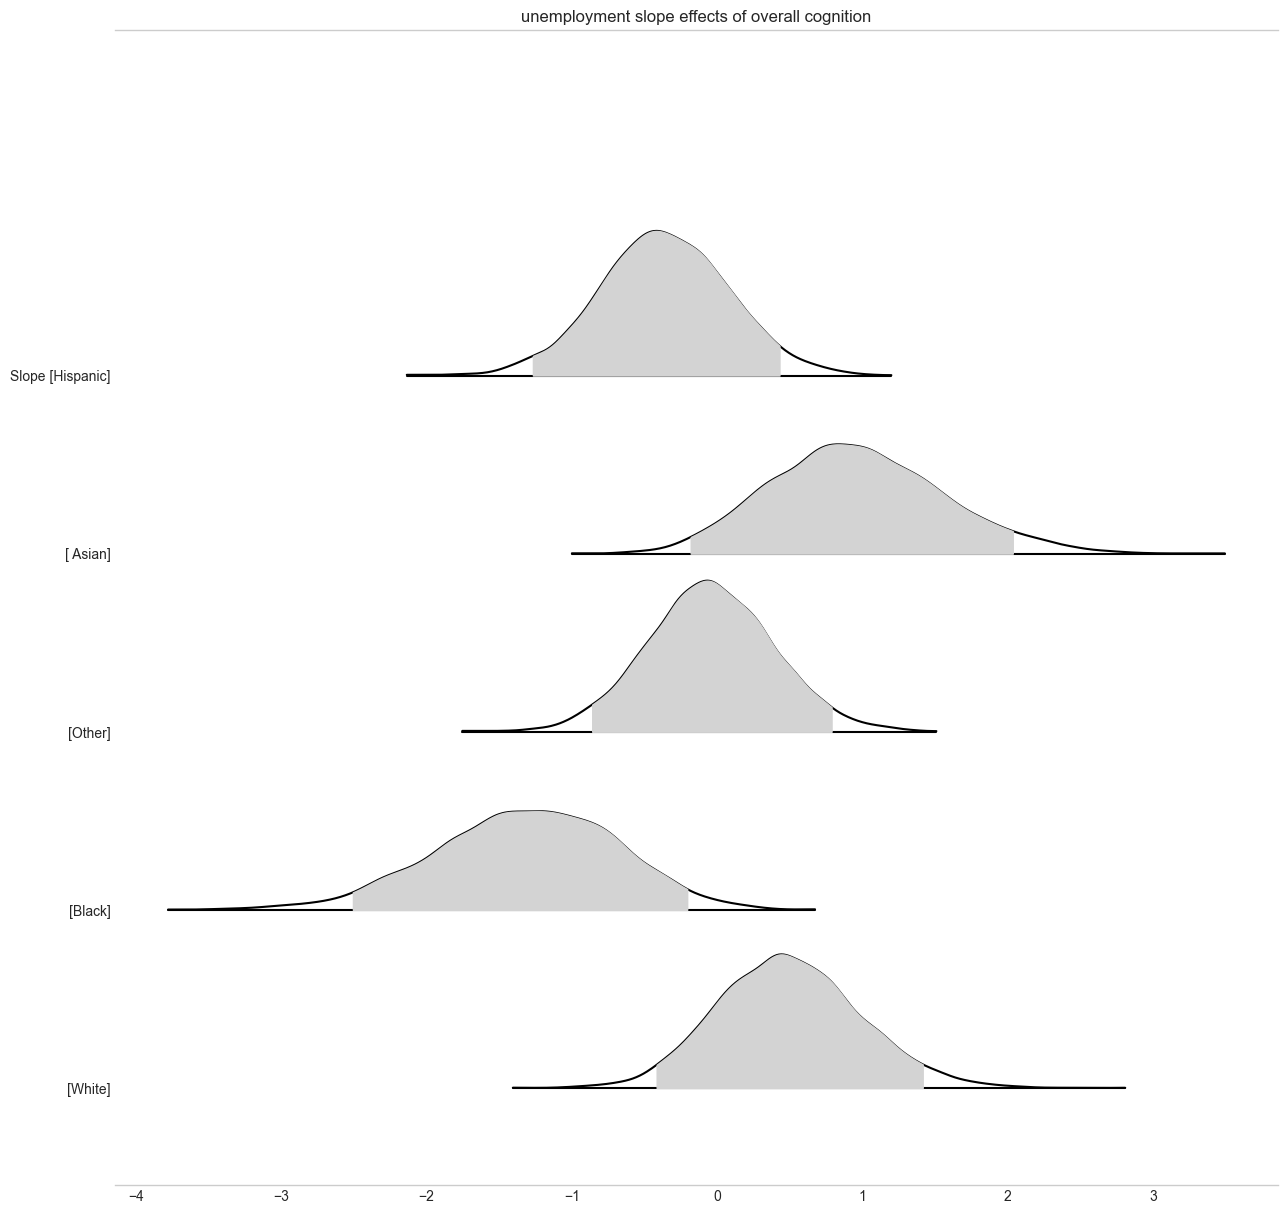

In [10]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("unemployment slope effects of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_unemp_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [11]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [12]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.372070
r2_std    0.003586
dtype: float64

In [13]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [14]:
# get race, state and census unemployment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_unemp_df = pd.DataFrame(data['reshist_addr1_adi_unemp_bin'],columns =['reshist_addr1_adi_unemp_bin']).reset_index(drop=True)


In [15]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_unemp_df,ppc_df,left_index=True, right_index=True)


In [16]:
ppc_unemp_race_mean = (ppc_df.groupby(['reshist_addr1_adi_unemp_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_unemp_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.200568  0.361759  0.244572   
                            Black           0.243986  0.159030  0.231062   
                            Hispanic        0.178427  0.164259  0.211136   
                            Other           0.211806  0.227590  0.167133   
                            White           0.265142  0.260929  0.243150   
1.0                         Asian           0.691950  0.455098  0.195032   
                            Black          -0.857038 -0.877626 -0.886148   
                            Hispanic       -0.349606 -0.293637 -0.380496   
                            Other          -0.169738 -0.287877 -0.118465   
                            White           0.129113  0.131516  0.136701   

                                            pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.131140  0.219457  0.197857   
                            Black           0.189812  0.283763  0.145197   
                            Hispanic        0.227551  0.237911  0.199883   
                            Other           0.258098  0.235670  0.164827   
                            White           0.280163  0.297519  0.245722   
1.0                         Asian           0.785083  0.286629  0.340781   
                            Black          -0.852131 -0.907680 -0.858268   
                            Hispanic       -0.279285 -0.306676 -0.339055   
                            Other          -0.092192 -0.071743 -0.179365   
                            White           0.153289  0.138606  0.154884   

                                            pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.267360  0.240970  0.324204   
                            Black           0.297758  0.191923  0.293890   
                            Hispanic        0.232117  0.173517  0.256345   
                            Other           0.180673  0.147847  0.231280   
                            White           0.253062  0.255858  0.250231   
1.0                         Asian           0.267623  0.613630  0.477960   
                            Black          -0.927799 -0.868422 -0.900580   
                            Hispanic       -0.327753 -0.320214 -0.285568   
                            Other          -0.209240 -0.154974 -0.146411   
                            White           0.165684  0.156477  0.117981   

                                            pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_unemp_bin race_ethnicity            ...                
0.0                         Asian           0.210342  ...     0.164354   
                            Black           0.168315  ...     0.138434   
                            Hispanic        0.272888  ...     0.215564   
                            Other           0.184317  ...     0.208406   
                            White           0.275497  ...     0.250405   
1.0                         Asian           0.730086  ...     0.366519   
                            Black          -0.856892  ...    -0.877599   
                            Hispanic       -0.337313  ...    -0.277766   
                            Other          -0.203199  ...    -0.141179   
                            White           0.157842  ...     0.189440   

                                            pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_unemp_bin race_ethnicity                             
0.0                         Asian              0.185601     0.308782   
                            Black              0.226661     0.157187   
                            Hispanic           0.252657     0.257784   
                            Other              0.210018 

In [17]:
ppc_unemp_race_mean_summ=ppc_unemp_race_mean.mean(axis=1)
ppc_unemp_race_mean_summ

reshist_addr1_adi_unemp_bin  race_ethnicity
0.0                          Asian             0.271336
                             Black             0.203130
                             Hispanic          0.213440
                             Other             0.221171
                             White             0.256131
1.0                          Asian             0.456426
                             Black            -0.890184
                             Hispanic         -0.312081
                             Other            -0.167025
                             White             0.151327
dtype: float64

In [18]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.376802,0.395235,0.226804,0.365677,0.243548,0.249117,0.267454,0.374625,0.379349,0.396748,...,0.236860,0.296792,0.375154,0.302171,0.402301,0.562109,0.430494,0.340213,0.351593,0.205227
Black,-0.654427,-0.686859,-0.680558,-0.660392,-0.688429,-0.673609,-0.702271,-0.673297,-0.680773,-0.668232,...,-0.690628,-0.739875,-0.744448,-0.649207,-0.667674,-0.711015,-0.691257,-0.740811,-0.640615,-0.731118
Hispanic,-0.186334,-0.152052,-0.197559,-0.122567,-0.138286,-0.172411,-0.154637,-0.167549,-0.118004,-0.148634,...,-0.125225,-0.110381,-0.148427,-0.146445,-0.127967,-0.169804,-0.157702,-0.121131,-0.142086,-0.145181
Other,0.023564,-0.026725,0.026228,0.085276,0.084002,-0.004987,-0.011698,-0.001555,0.044939,-0.006871,...,0.035932,0.035352,0.067766,0.067287,0.088369,0.019086,0.009917,-0.019961,-0.012244,0.046487
White,0.217384,0.215494,0.205778,0.235620,0.241727,0.213831,0.222385,0.220967,0.203800,0.234191,...,0.229001,0.162017,0.220445,0.215651,0.205628,0.201881,0.202731,0.248110,0.227213,0.220298


In [19]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [20]:
ppc_unemp_state_mean = (ppc_df.groupby(['reshist_addr1_adi_unemp_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_unemp_state_mean_summ = ppc_unemp_state_mean.mean(axis=1)


In [21]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [22]:
ppc_unemp_state_mean_summ_list=ppc_unemp_state_mean_summ.to_numpy()
low_unemp_state = ppc_unemp_state_mean_summ_list[:17]
high_unemp_state = ppc_unemp_state_mean_summ_list[-17:]

In [23]:
mean_predictions_state = [low_unemp_state,high_unemp_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.300974,0.233447,0.329229,0.058503,0.177891,0.237809,0.368946,0.175956,0.244007,0.041737,0.353087,-0.076185,0.205265,0.273262,0.309617,0.245436,0.402575
1,-0.126289,-0.112865,-0.126921,-0.451977,-0.562967,-0.193903,0.164662,-0.396004,-0.373789,-0.426882,0.128059,-0.778687,-0.285510,0.062086,0.173104,-0.330995,0.041143


In [24]:
ppc_unemp_race_mean_summ_list=ppc_unemp_race_mean_summ.to_numpy()
low_unemp_race = ppc_unemp_race_mean_summ_list[:5]
high_unemp_race = ppc_unemp_race_mean_summ_list[-5:]

In [25]:
# initialize list of lists 
mean_predictions_race = [low_unemp_race,high_unemp_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.271336,0.203130,0.213440,0.221171,0.256131
1,0.456426,-0.890184,-0.312081,-0.167025,0.151327


In [26]:
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset2.csv', usecols=['state','Nonemployed_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [27]:
val = census_data['Nonemployed_score'].median()
census_data.loc[census_data['Nonemployed_score'] < val, 'Nonemployed_score_bin'] = 0
census_data.loc[census_data['Nonemployed_score'] >= val, 'Nonemployed_score_bin'] = 1

In [28]:
census = (census_data.groupby(['state','race_ethnicity','Nonemployed_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Nonemployed_score_bin,freq
0,california,Asian,0.0,1152935
1,california,Asian,1.0,883459
2,california,Black,0.0,3316073
3,california,Black,1.0,63912
4,california,Hispanic,0.0,14796648
...,...,...,...,...
130,wisconsin,Black,1.0,26478
131,wisconsin,Hispanic,0.0,148384
132,wisconsin,Other,0.0,117894
133,wisconsin,White,0.0,5289156


In [29]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Nonemployed_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,1152935,1,0
1,california,Asian,1.0,883459,1,0
2,california,Black,0.0,3316073,3,0
3,california,Black,1.0,63912,3,0
4,california,Hispanic,0.0,14796648,0,0


In [30]:
#fix theano shared tensor type error
census=census.astype({'Nonemployed_score_bin':'uint8'})

In [31]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_unemp = census.Nonemployed_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
unemp_.set_value(ps_unemp)

In [32]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [33]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(135, 8000)

In [34]:
censust=census
censust

,state,race_ethnicity,Nonemployed_score_bin,freq,race_enc,state_enc
0,california,Asian,0,1152935,1,0
1,california,Asian,1,883459,1,0
2,california,Black,0,3316073,3,0
3,california,Black,1,63912,3,0
4,california,Hispanic,0,14796648,0,0
...,...,...,...,...,...,...
130,wisconsin,Black,1,26478,3,16
131,wisconsin,Hispanic,0,148384,0,16
132,wisconsin,Other,0,117894,2,16
133,wisconsin,White,0,5289156,4,16


In [35]:
# get race, state, and census unemployment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_unemp_df2 = pd.DataFrame(censust['Nonemployed_score_bin'],columns =['Nonemployed_score_bin']).reset_index(drop=True)


In [36]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_unemp_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Nonemployed_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1152935,1.251510,0.269156,-1.160878,-0.348576,0.690370,-0.619028,...,0.406804,1.256622,0.940342,-0.670673,0.265524,-1.857615,-0.724197,0.514365,-0.804676,2.342851
1,california,Asian,1,883459,-0.687635,2.587574,-0.600979,0.593347,-1.021812,1.104611,...,-0.035086,0.727527,-0.087169,0.528615,0.141528,-0.421116,0.866720,2.066894,0.300916,-0.627967
2,california,Black,0,3316073,-0.570625,-0.440676,-0.107216,1.472643,0.896338,1.044354,...,0.334505,0.345418,-0.213098,0.660323,-0.822063,1.583094,1.803464,0.769764,0.038830,-1.555662
3,california,Black,1,63912,-0.061081,-0.683708,-1.764039,1.302254,-0.046736,-0.711989,...,-1.913560,-0.245646,-0.660387,-0.445928,-1.754198,-1.987524,0.343675,-0.006205,-1.023451,-0.802892
4,california,Hispanic,0,14796648,0.068999,0.350450,1.684277,0.269928,-0.687288,0.137673,...,0.123931,0.514509,0.995504,1.859893,-1.329025,-0.165212,-0.073577,1.064564,-0.616728,-0.420847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,wisconsin,Black,1,26478,-0.020458,-1.265657,-2.644884,0.201029,0.508993,-0.866148,...,-0.438820,-0.011163,-2.288979,-0.621425,-1.188367,-0.746648,-0.730973,0.198019,-2.197197,-0.003333
131,wisconsin,Hispanic,0,148384,0.172282,-0.668686,1.280940,1.200334,0.592772,0.557832,...,0.141918,1.368116,0.067478,0.102911,-0.411570,-0.930040,0.569043,0.010178,-0.694753,0.723108
132,wisconsin,Other,0,117894,1.410494,0.965585,-0.568497,0.006272,1.126048,-1.035505,...,2.125101,0.000542,0.774578,1.726904,-0.736209,0.647086,0.147960,0.999145,0.279743,1.463209
133,wisconsin,White,0,5289156,1.398524,2.013953,0.384859,0.363485,-1.679994,0.426318,...,-1.139366,0.487253,-0.956108,0.425697,-0.400217,0.151308,1.100193,2.471065,0.864264,-0.129749


In [37]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Nonemployed_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0    1.442910e+06   
                          1                     1   -6.074977e+05   
           Black          0                     2   -1.892235e+06   
                          1                     3   -3.903785e+03   
           Hispanic       0                     4    1.020956e+06   
...                                                           ...   
wisconsin  Black          1                     130 -5.416902e+02   
           Hispanic       0                     131  2.556395e+04   
           Other          0                     132  1.662887e+05   
           White          0                     133  7.397012e+06   
                          1                     134 -1.563552e+04   

                                                         pp_cog_1  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0    3.103196e+05   
                          1                     1    2.286016e+06   
           Black          0                     2   -1.461313e+06   
                          1                     3   -4.369714e+04   
           Hispanic       0                     4    5.185480e+06   
...                                                           ...   
wisconsin  Black          1                     130 -3.351207e+04   
           Hispanic       0                     131 -9.922235e+04   
           Other          0                     132  1.138367e+05   
           White          0                     133  1.065211e+07   
                          1                     134  8.357919e+04   

                                                         pp_cog_2  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -1.338417e+06   
                          1                     1   -5.309400e+05   
           Black          0                     2   -3.555359e+05   
                          1                     3   -1.127433e+05   
           Hispanic       0                     4    2.492165e+07   
...                                                           ...   
wisconsin  Black          1                     130 -7.003124e+04   
           Hispanic       0                     131  1.900710e+05   
           Other          0                     132 -6.702237e+04   
           White          0                     133  2.035582e+06   
                          1                     134 -9.902979e+04   

                                                         pp_cog_3  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -4.018854e+05   
                          1                     1    5.241980e+05   
           Black          0                     2    4.883390e+06   
                          1                     3    8.322964e+04   
           Hispanic       0                     4    3.994027e+06   
...                                                           ...   
wisconsin  Black          1                     130  5.322835e+03   
           Hispanic       0                     131  1.781103e+05   
           Other          0                     132  7.393867e+02   
           White          0                     133  1.922530e+06   
                          1                     134 -4.634986e+04   

                                                         pp_cog_4  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0    7.959513e+05   
                          1                     1   -9.027287e+05   
           Black          0                     2    2.972323e+06   
                          1                     3   -2.986970e+03   
           Hispanic       0                     4  

In [38]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,1.442910e+06,3.103196e+05,-1.338417e+06,-4.018854e+05,7.959513e+05,-7.136996e+05,3.312902e+05,-6.287633e+05,-1.385468e+05,5.603751e+05,...,4.690182e+05,1.448804e+06,1.084153e+06,-7.732421e+05,3.061321e+05,-2.141710e+06,-8.349515e+05,5.930294e+05,-9.277394e+05,2.701155e+06
1,-6.074977e+05,2.286016e+06,-5.309400e+05,5.241980e+05,-9.027287e+05,9.758781e+05,8.006532e+05,1.508284e+06,5.124299e+05,2.769558e+05,...,-3.099688e+04,6.427406e+05,-7.701042e+04,4.670100e+05,1.250339e+05,-3.720384e+05,7.657118e+05,1.826016e+06,2.658472e+05,-5.547830e+05
2,-1.892235e+06,-1.461313e+06,-3.555359e+05,4.883390e+06,2.972323e+06,3.463155e+06,2.224002e+06,1.309594e+06,5.894748e+06,-2.034465e+06,...,1.109244e+06,1.145430e+06,-7.066498e+05,2.189679e+06,-2.726021e+06,5.249654e+06,5.980418e+06,2.552593e+06,1.287644e+05,-5.158689e+06
3,-3.903785e+03,-4.369714e+04,-1.127433e+05,8.322964e+04,-2.986970e+03,-4.550467e+04,2.442055e+04,-1.311613e+05,-4.157823e+04,2.406070e+04,...,-1.222994e+05,-1.569971e+04,-4.220668e+04,-2.850018e+04,-1.121143e+05,-1.270266e+05,2.196498e+04,-3.965542e+02,-6.541083e+04,-5.131441e+04
4,1.020956e+06,5.185480e+06,2.492165e+07,3.994027e+06,-1.016955e+07,2.037099e+06,1.839982e+07,-8.250239e+06,1.004462e+07,-1.637163e+07,...,1.833764e+06,7.613007e+06,1.473012e+07,2.752018e+07,-1.966511e+07,-2.444577e+06,-1.088693e+06,1.575198e+07,-9.125503e+06,-6.227126e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,-5.416902e+02,-3.351207e+04,-7.003124e+04,5.322835e+03,1.347713e+04,-2.293388e+04,-2.209246e+04,-4.257887e+03,-3.328651e+04,-3.335359e+04,...,-1.161907e+04,-2.955714e+02,-6.060760e+04,-1.645409e+04,-3.146557e+04,-1.976975e+04,-1.935470e+04,5.243151e+03,-5.817739e+04,-8.824664e+01
131,2.556395e+04,-9.922235e+04,1.900710e+05,1.781103e+05,8.795788e+04,8.277334e+04,2.832226e+05,1.828250e+05,2.717423e+04,-2.387012e+04,...,2.105835e+04,2.030065e+05,1.001270e+04,1.527040e+04,-6.107047e+04,-1.380031e+05,8.443692e+04,1.510231e+03,-1.030902e+05,1.072977e+05
132,1.662887e+05,1.138367e+05,-6.702237e+04,7.393867e+02,1.327543e+05,-1.220798e+05,-4.030017e+04,-1.694915e+04,-2.725217e+04,4.308317e+04,...,2.505367e+05,6.391419e+01,9.131811e+04,2.035917e+05,-8.679466e+04,7.628754e+04,1.744359e+04,1.177932e+05,3.297997e+04,1.725035e+05
133,7.397012e+06,1.065211e+07,2.035582e+06,1.922530e+06,-8.885751e+06,2.254862e+06,1.507090e+06,-7.137440e+06,2.805282e+06,5.306381e+06,...,-6.026287e+06,2.577155e+06,-5.057004e+06,2.251578e+06,-2.116811e+06,8.002902e+05,5.819093e+06,1.306985e+07,4.571227e+06,-6.862620e+05


In [39]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Nonemployed_score_bin,freq
0,california,Asian,0,1152935
1,california,Asian,1,883459
2,california,Black,0,3316073
3,california,Black,1,63912
4,california,Hispanic,0,14796648
...,...,...,...,...
130,wisconsin,Black,1,26478
131,wisconsin,Hispanic,0,148384
132,wisconsin,Other,0,117894
133,wisconsin,White,0,5289156


In [40]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Nonemployed_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1152935,1.442910e+06,3.103196e+05,-1.338417e+06,-4.018854e+05,7.959513e+05,-7.136996e+05,...,4.690182e+05,1.448804e+06,1.084153e+06,-7.732421e+05,3.061321e+05,-2.141710e+06,-8.349515e+05,5.930294e+05,-9.277394e+05,2.701155e+06
1,california,Asian,1,883459,-6.074977e+05,2.286016e+06,-5.309400e+05,5.241980e+05,-9.027287e+05,9.758781e+05,...,-3.099688e+04,6.427406e+05,-7.701042e+04,4.670100e+05,1.250339e+05,-3.720384e+05,7.657118e+05,1.826016e+06,2.658472e+05,-5.547830e+05
2,california,Black,0,3316073,-1.892235e+06,-1.461313e+06,-3.555359e+05,4.883390e+06,2.972323e+06,3.463155e+06,...,1.109244e+06,1.145430e+06,-7.066498e+05,2.189679e+06,-2.726021e+06,5.249654e+06,5.980418e+06,2.552593e+06,1.287644e+05,-5.158689e+06
3,california,Black,1,63912,-3.903785e+03,-4.369714e+04,-1.127433e+05,8.322964e+04,-2.986970e+03,-4.550467e+04,...,-1.222994e+05,-1.569971e+04,-4.220668e+04,-2.850018e+04,-1.121143e+05,-1.270266e+05,2.196498e+04,-3.965542e+02,-6.541083e+04,-5.131441e+04
4,california,Hispanic,0,14796648,1.020956e+06,5.185480e+06,2.492165e+07,3.994027e+06,-1.016955e+07,2.037099e+06,...,1.833764e+06,7.613007e+06,1.473012e+07,2.752018e+07,-1.966511e+07,-2.444577e+06,-1.088693e+06,1.575198e+07,-9.125503e+06,-6.227126e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,wisconsin,Black,1,26478,-5.416902e+02,-3.351207e+04,-7.003124e+04,5.322835e+03,1.347713e+04,-2.293388e+04,...,-1.161907e+04,-2.955714e+02,-6.060760e+04,-1.645409e+04,-3.146557e+04,-1.976975e+04,-1.935470e+04,5.243151e+03,-5.817739e+04,-8.824664e+01
131,wisconsin,Hispanic,0,148384,2.556395e+04,-9.922235e+04,1.900710e+05,1.781103e+05,8.795788e+04,8.277334e+04,...,2.105835e+04,2.030065e+05,1.001270e+04,1.527040e+04,-6.107047e+04,-1.380031e+05,8.443692e+04,1.510231e+03,-1.030902e+05,1.072977e+05
132,wisconsin,Other,0,117894,1.662887e+05,1.138367e+05,-6.702237e+04,7.393867e+02,1.327543e+05,-1.220798e+05,...,2.505367e+05,6.391419e+01,9.131811e+04,2.035917e+05,-8.679466e+04,7.628754e+04,1.744359e+04,1.177932e+05,3.297997e+04,1.725035e+05
133,wisconsin,White,0,5289156,7.397012e+06,1.065211e+07,2.035582e+06,1.922530e+06,-8.885751e+06,2.254862e+06,...,-6.026287e+06,2.577155e+06,-5.057004e+06,2.251578e+06,-2.116811e+06,8.002902e+05,5.819093e+06,1.306985e+07,4.571227e+06,-6.862620e+05


In [41]:
#final step of poststratification - by race & unemp 
#data-weighted average
ppc_unemp_race_poststrat = ppc_poststrat_df.groupby(['Nonemployed_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_unemp_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  pp_cog_3  \
Nonemployed_score_bin race_ethnicity                                           
0                     Asian           0.579225  0.120405 -0.287973  0.175752   
                      Black           0.084848  0.100072  0.378401  0.272330   
                      Hispanic        0.409525  0.245964  1.444491  0.555055   
                      Other           0.202776  0.034629  0.825574  0.153239   
                      White           0.733562  0.481502 -0.131216  0.320776   
1                     Asian          -0.179725  1.534481 -0.161763  0.648157   
                      Black          -0.820538 -0.343978 -1.716125 -0.489887   
                      Hispanic       -0.921894  0.217749 -0.748418 -0.761296   
                      Other          -0.792254  0.363664 -0.009063  0.909849   
                      White          -0.761140  0.563134 -0.431983 -0.484711   

                                      pp_cog_4  pp_cog_5  pp_cog_6  pp_cog_7  \
Nonemployed_score_bin race_ethnicity                                           
0                     Asian          -0.172798  0.402512  0.225314 -0.015157   
                      Black           0.317668  0.376968  0.539039 -0.039031   
                      Hispanic       -0.582713  0.206917  0.534758 -0.389302   
                      Other           0.266059  0.542149 -0.155799 -0.083069   
                      White           0.154922  0.299516  0.700299  0.248106   
1                     Asian          -0.360128  0.900844  0.976591  1.254000   
                      Black          -1.081367 -1.257537 -0.283462 -0.813457   
                      Hispanic       -0.035007 -0.831331 -0.915018 -0.774977   
                      Other          -1.003182  0.151361 -0.968870 -0.296350   
                      White           0.137213  0.354823  0.004751 -0.442878   

                                      pp_cog_8  pp_cog_9  ...  pp_cog_7990  \
Nonemployed_score_bin race_ethnicity                      ...                
0                     Asian          -0.140730  0.117913  ...     0.131149   
                      Black           0.781148 -0.167607  ...     0.164776   
                      Hispanic        0.479153 -0.518799  ...    -0.038382   
                      Other          -0.365831 -0.414481  ...     0.078248   
                      White           0.189513  0.518283  ...     0.348705   
1                     Asian           0.593304  0.312511  ...     0.358418   
                      Black          -0.635933 -0.856612  ...    -0.514634   
                      Hispanic       -0.530326 -0.668709  ...    -0.040296   
                      Other           0.214352  0.556078  ...    -0.512330   
                      White          -0.600499  0.207042  ...     0.230035   

                                      pp_cog_7991  pp_cog_7992  pp_cog_7993  \
Nonemployed_score_bin race_ethnicity                                          
0                     Asian              0.488876     0.473254    -0.042634   
                      Black              0.133168     0.434656     0.178943   
                      Hispanic           0.133799     1.003527     0.936876   
                      Other             -0.146169    -0.220509    -0.586057   
                      White             -0.030069     0.205241     0.227595   
1                     Asian              0.777346     0.429259     0.494717   
                      Black             -0.879409    -0.696767    -0.493691   
                      Hispanic           0.602884    -0.625845    -0.019432   
                      Other              0.876946     0.050024    -0.209361   
                      White             -0.293985    -0.059572     0.344211   

                                      pp_cog_7994  pp_cog_7995  pp_cog_7996  \
Nonemployed_score_bin race_ethnicity                                          
0                     Asian              0.533339    -0.361670     0.299

In [42]:
#summarize race & unemp poststrat results
ppc_unemp_race_poststrat_summ = ppc_unemp_race_poststrat.mean(axis=1)
ppc_unemp_race_poststrat_summ

Nonemployed_score_bin  race_ethnicity
0                      Asian             0.195184
                       Black             0.232117
                       Hispanic          0.229749
                       Other             0.160803
                       White             0.216087
1                      Asian             0.425245
                       Black            -0.890525
                       Hispanic         -0.308626
                       Other            -0.103300
                       White             0.080566
dtype: float64

In [43]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.259615
Black      -0.047402
Hispanic    0.054217
Other       0.027726
White       0.174515
dtype: float64

In [44]:
#for the lollipops
#final step poststrat - by state & unemp
ppc_unemp_state_poststrat = ppc_poststrat_df.groupby(['Nonemployed_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_unemp_state_poststrat_summ = ppc_unemp_state_poststrat.mean(axis=1)
ppc_unemp_state_poststrat_summ

Nonemployed_score_bin  state        
0                      california       0.312487
                       colorado         0.228612
                       connecticut      0.316280
                       florida          0.047445
                       maryland         0.182246
                       michigan         0.238840
                       minnesota        0.384986
                       missouri         0.167006
                       newyork          0.227486
                       oklahoma         0.053321
                       oregon           0.364577
                       pennsylvania    -0.081548
                       southcarolina    0.207157
                       utah             0.260548
                       vermont          0.327068
                       virginia         0.238545
                       wisconsin        0.399867
1                      california      -0.060325
                       colorado        -0.193613
                       florida  

In [45]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.185266
colorado         0.193281
connecticut      0.316280
florida         -0.134277
maryland         0.024386
michigan         0.141702
minnesota        0.383221
missouri         0.095374
newyork          0.133022
oklahoma        -0.032234
oregon           0.248457
pennsylvania    -0.126792
southcarolina    0.040384
utah             0.250908
vermont          0.316477
virginia         0.185653
wisconsin        0.394078
dtype: float64

In [46]:
ppc_unemp_state_poststrat_summ_list=ppc_unemp_state_poststrat_summ.tolist()

In [47]:
#fill in missing value for connecticut
ppc_unemp_state_poststrat_summ_list.insert(19,ppc_unemp_state_mean_summ.iloc[19])

In [49]:
low_unemp_state_poststrat = ppc_unemp_state_poststrat_summ_list[:17]
high_unemp_state_poststrat = ppc_unemp_state_poststrat_summ_list[-17:]

In [50]:
ppc_unemp_race_poststrat_summ_list=ppc_unemp_race_poststrat_summ.tolist()

In [51]:
low_unemp_race_poststrat = ppc_unemp_race_poststrat_summ_list[:5]
high_unemp_race_poststrat = ppc_unemp_race_poststrat_summ_list[-5:]

In [52]:
mean_predictions_state_ps = [low_unemp_state_poststrat,high_unemp_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.312487,0.228612,0.316280,0.047445,0.182246,0.238840,0.384986,0.167006,0.227486,0.053321,0.364577,-0.081548,0.207157,0.260548,0.327068,0.238545,0.399867
1,-0.060325,-0.193613,-0.126921,-0.375302,-0.808660,0.040843,0.190829,-0.118090,-0.036041,-0.144745,0.134317,-0.228180,-0.118183,0.105770,-0.739398,0.017832,0.092792


In [53]:
# initialize list of lists 
mean_predictions_race_ps = [low_unemp_race_poststrat,high_unemp_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.195184,0.232117,0.229749,0.160803,0.216087
1,0.425245,-0.890525,-0.308626,-0.103300,0.080566


In [54]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.016816408214534534,
  0.1290704382924182,
  0.06350990539055373,
  -0.3090919275234392,
  -0.16423514833625757,
  -0.00837883197544241,
  0.3200615905966521,
  -0.15483612900559263,
  0.010699332605489708,
  -0.14248985192719893,
  0.20410422763050307,
  -0.6540690099400945,
  -0.06480661956881303,
  0.21923623410606097,
  0.28240780094780604,
  -0.007324172827891197,
  0.3002663084077115],
 [0.1864693938448838,
  0.1957157303835111,
  0.3170523938130911,
  -0.1348582649100671,
  0.027002329578109073,
  0.14642324390495548,
  0.3805939595059008,
  0.09342374498555284,
  0.13520476043016527,
  -0.039994376956400374,
  0.2505920862500416,
  -0.12477072630526051,
  0.04452381892649428,
  0.24238625376446354,
  0.32017397712217177,
  0.19031785091723236,
  0.3926957074662537])

In [55]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

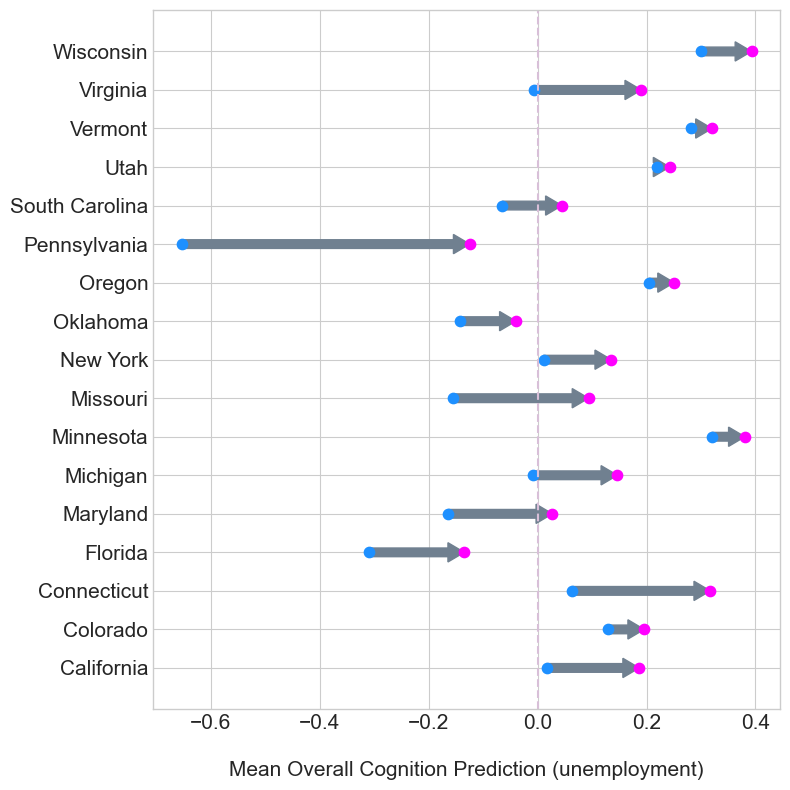

In [56]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (unemployment)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Unemployment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_unemp_overall_ps_state_cognition_results_f4_v2.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [57]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.3372742004806316,
  -0.6889316187473622,
  -0.1494386296823247,
  0.029663379768723484,
  0.21924198330168432],
 [0.24293003739525798,
  -0.017660707176532463,
  0.06042673926090554,
  -0.07812148170752553,
  0.1956738946055324])

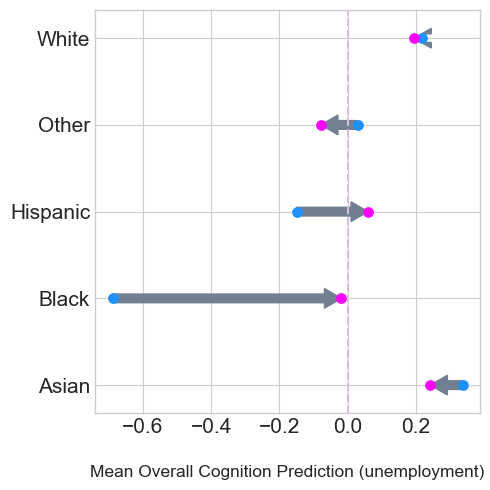

In [58]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (unemployment)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Unemployment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_unemp_overall_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_92256/865970624.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_92256/865970624.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


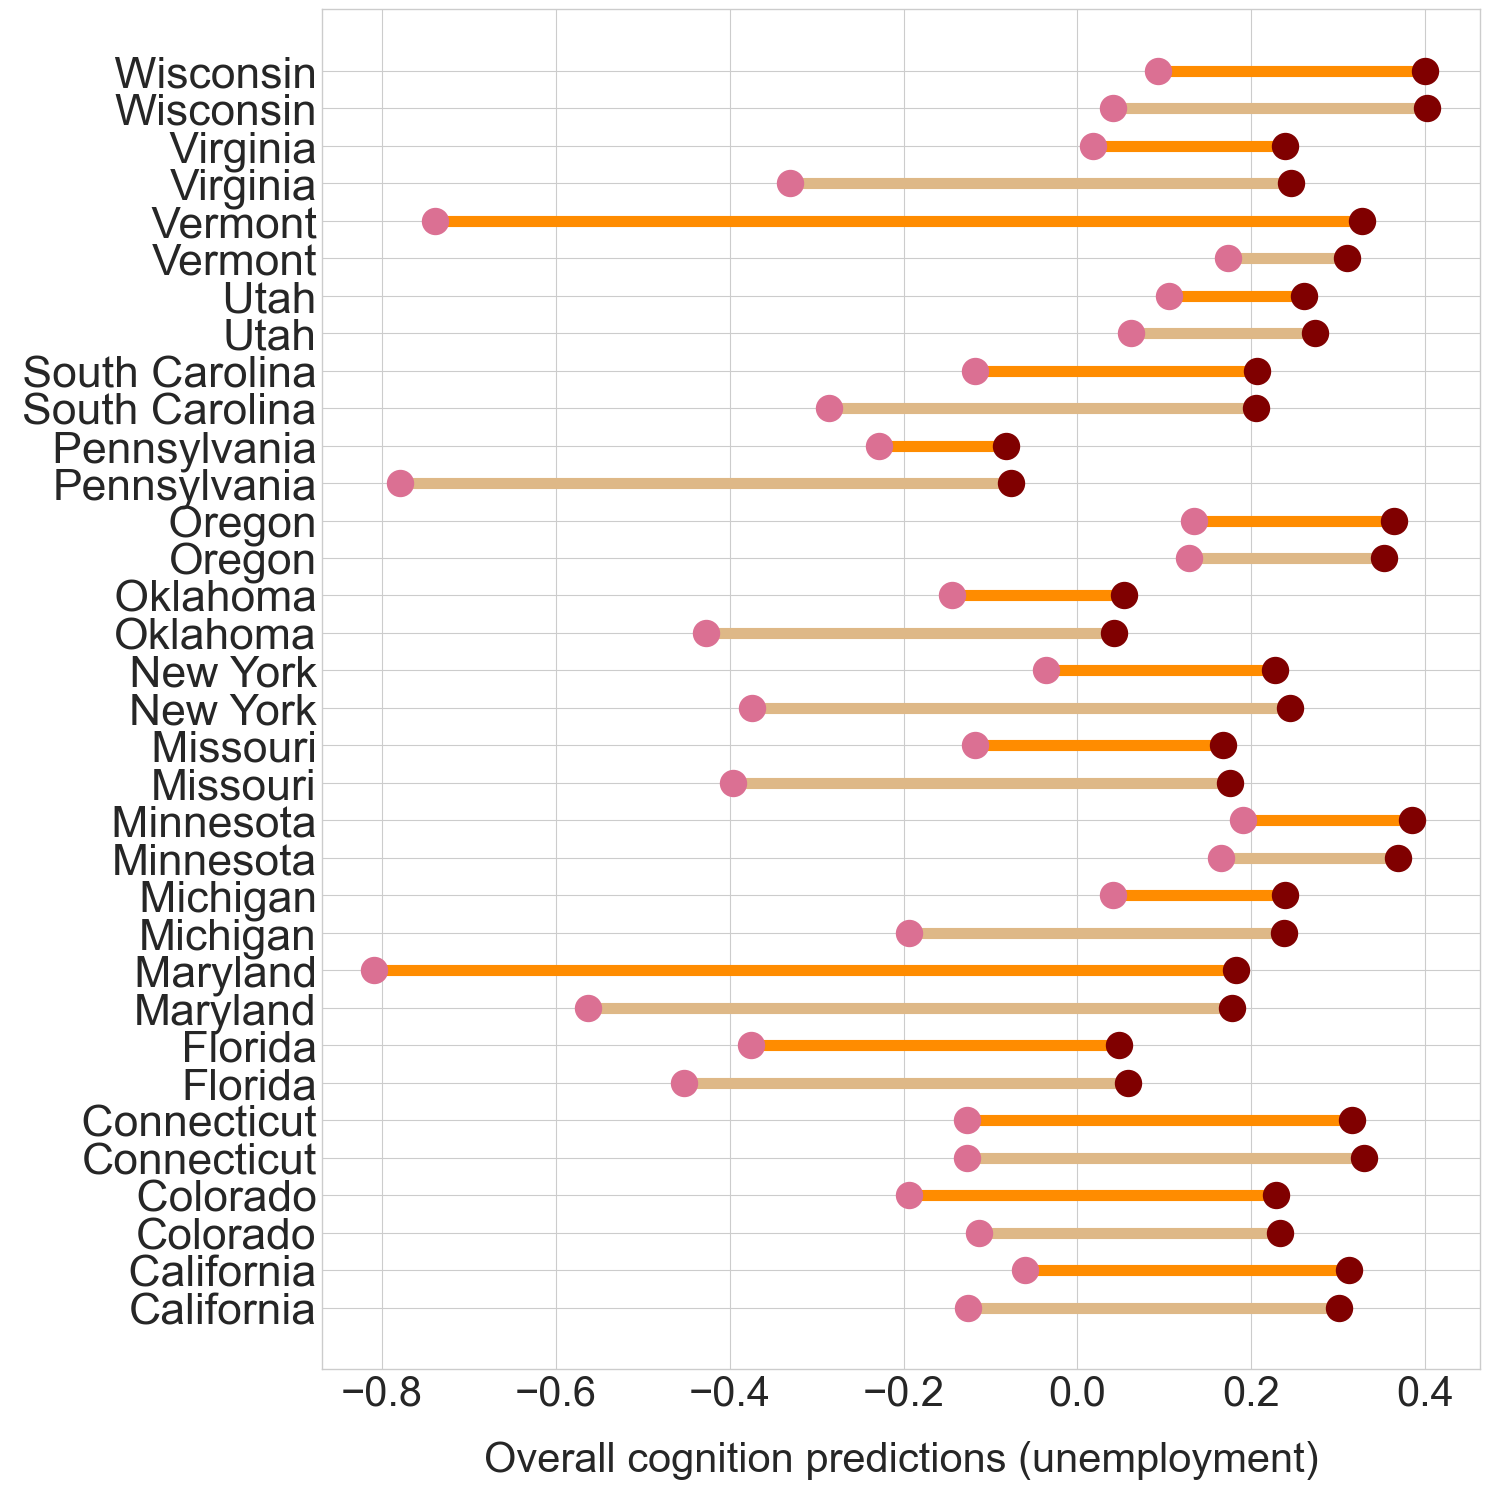

In [57]:
#low_state_edu2,high_state_edu2,low_state_edu,high_state_edu
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='maroon', label='low unemp', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='palevioletred', label='high unemp', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='maroon', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='palevioletred', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (unemployment)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low unemp', 'high unemp'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_unemp_overall_ps_state_cognition_results_f5_v2.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_51482/3897245240.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_51482/3897245240.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


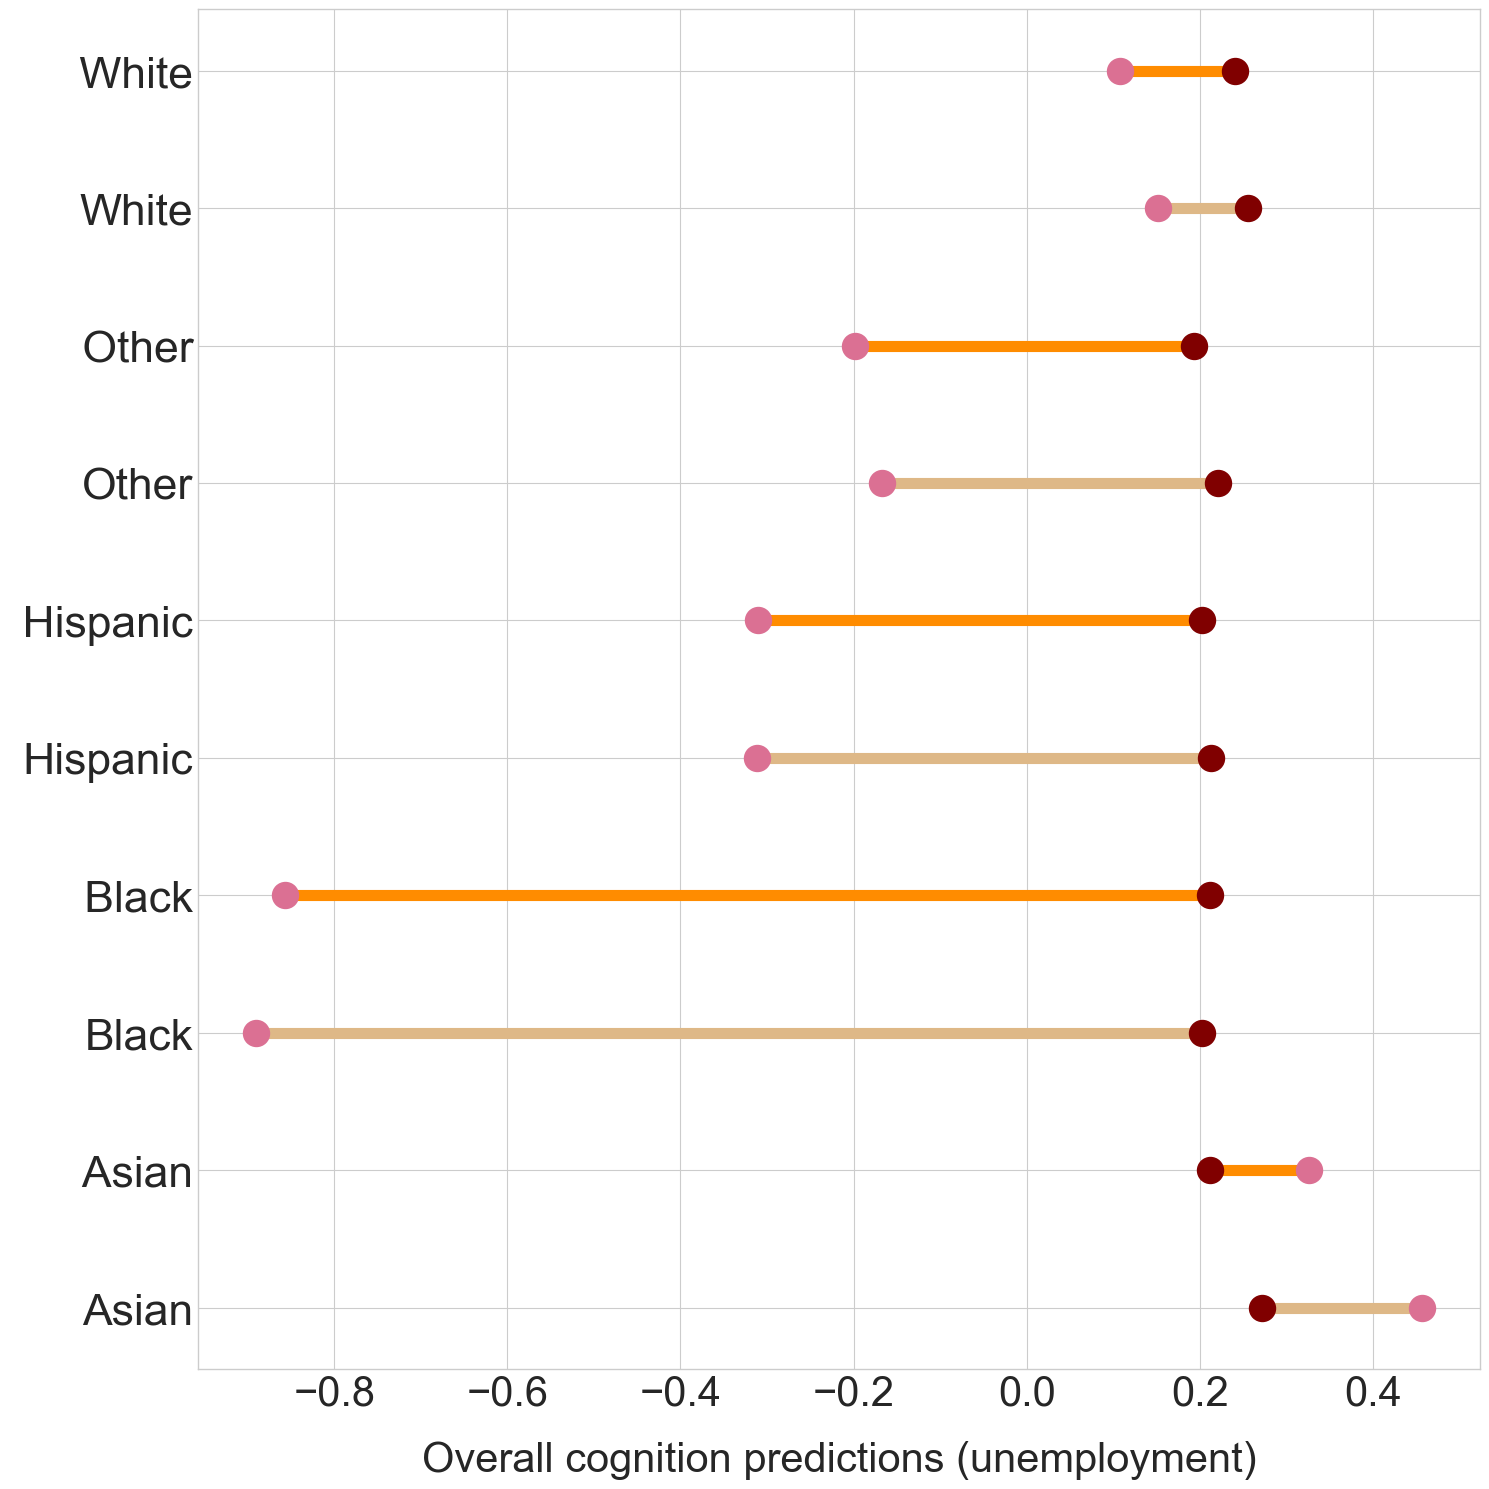

In [60]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='maroon', label='low unemp', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='palevioletred', label='high unemp', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='maroon', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='palevioletred', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (unemployment)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low unemp', 'high unemp'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_unemp_overall_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()